
-----------------------------------------------------
### Notebook Documentation.
#### 1. TFM
---------------------------------
Different architectures / parameters.


In [ ]:
# Google Drive stuff
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


- libraries

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
%tensorflow_version 2.x
# batch ingestion of pics without pickle
from tensorflow.keras.preprocessing import image_dataset_from_directory

# nns
from tensorflow.keras.applications import VGG16, VGG19,Xception, InceptionResNetV2, DenseNet121, ResNet50 

from tensorflow.keras import Model
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras import layers # for data augmentation
#from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, MaxPooling2D, Flatten # Input, Conv2D, 
#from tensorflow.keras.layers import Layer

# optimization
from tensorflow.keras.optimizers import Adam #, SGD
from tensorflow.keras.losses import SparseCategoricalCrossentropy, categorical_crossentropy
from tensorflow.keras.callbacks import EarlyStopping

# metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
#from sklearn.metrics import plot_precision_recall_curve
from itertools import chain # to flatten the real labels array from validation set
import json # to save in a file metrics
#from datetime import datetime # to name results

# viz & arrays
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline



# my functions # i'll write here at the end the functions i'm using below
# from my_functions import freezing_layers, vgg16_19_conf, resnet50_conf, nn_parameters, plotting_model, generic_last_2layers

- paths

In [ ]:
# paths i'll use
base_folder = "/content/drive/My Drive/2-Estudios/viu-master_ai/tfm-deep_vision/"
input_folder = base_folder+"input/" #for pickling data
input = input_folder+"House_Room_Dataset-5_rooms" # for requesting directly pics
src_folder =  base_folder+"src/"
output_folder = base_folder + "/output/"

# insert the directory for using my functions in this notebook
import sys
sys.path.insert(0,"/content/drive/My Drive/2-Estudios/viu-master_ai/tfm-deep_vision/src/")

In [ ]:
!ls "/content/drive/My Drive/2-Estudios/viu-master_ai/tfm-deep_vision/"

 AlbertoVargas-sistema_clasificacion_viviendas_imagenes.gslides   input    src
'Dudas y seguimiento TFM.gdoc'					  output


- functions

In [ ]:
def vgg19_vgg16(data_augmentation, base_model, dropout_layers: bool, dropout_position: str, dropout_percent: float, num_classes):
  '''
  both architectures has the same top model, so we'll built:
  - a model with/without a data augmentation layer
  - the functional nn with frozen layers, whithout top model
  - "empty" top model layers, ready for transfer-learning, with/without dropout in first/middle layer of top model
  - final layer with as much neurons as our classes to infer
  EX: vgg19(data_augmentation=None, base_model= base_model_vgg19, dropout_layers=False, dropout_position= None, dropout_percent=None, num_classes=5)
  '''
  pre_trained = Sequential()

  if data_augmentation:
    #data augmentation
    pre_trained.add(data_augmentation)
    pre_trained.add(layers.Rescaling(1./255))
       
                                                                 
  # vgg16 (Functional)          
  pre_trained.add(base_model)

  # Freeze the layers 
  for layer in pre_trained.layers:
      layer.trainable = False

  # i had to insert this layer when using the data augmentation layer in order to avoid dimension errors with VGG16 and 19
  pre_trained.add(layers.GlobalAveragePooling2D())

  # adding top model with/without dropout in first/middle position
  # top moddel for vgg19-16 are a flatten layer, 2 dense layers of 4096n and pred layer 
  pre_trained.add(layers.Flatten())
  if dropout_layers is True:
      if dropout_position=="first":
          pre_trained.add(layers.Dropout(dropout_percent)) 
          pre_trained.add(layers.Dense(4096,activation=('relu')))

      elif dropout_position == "middle":                  
          pre_trained.add(layers.Dense(4096,activation=('relu')))
          pre_trained.add(layers.Dropout(dropout_percent)) 
      
  else: 
    pre_trained.add(layers.Dense(4096,activation=('relu')))
  
  pre_trained.add(layers.Dense(4096,activation=('relu')))
  pre_trained.add(layers.Dense(num_classes,activation=('softmax')))

  return pre_trained

def generic_last_2layers(data_augmentation, nn,neurons_final_layer:int,  dropout_layers: bool, dropout_position: str =="first", dropout_percent: float):
  '''
  Xception, InceptionResNetV2, DenseNet121 have different architecture, but all of them have the same top model. So we add the data augmentation layer,
  load the functional model and add the top model with/without dropout in first/middle position
  works with pre-trained models (Xception, InceptionResNetV2, DenseNet121) for transfer-learning. 
  top layer consisting of 2 layers: globalaverage2d layer and predictions layer.
  - nn                  = pre-trained model without top model
  - neurons_final_layer = how many classes we want to work with
  - dropout_layers      = bool. dropout in the top model (True/False)
  - dropout_position    = dropout layer before top model or between dense layers (first/middle)
  - dropout_percent     = (0,1). float
  EX: generic_last_2layers(Xception(include_top=False, 
                                    weights='imagenet', 
                                    input_shape=(128, 128, 3), 
                                    classes = num_classes, 
                                    classifier_activation='softmax'
                                    ), 
                          5, True, "first", 0.2
                          )
  '''
  pre_trained = Sequential()

  if data_augmentation:
    #data augmentation
    pre_trained.add(data_augmentation)
    pre_trained.add(layers.Rescaling(1./255))

  pre_trained.add(nn)

  # Freeze the layers 
  for layer in pre_trained.layers:
      layer.trainable = False

  #adding top model with/without dropout
  if dropout_layers is True:
      if dropout_position=="first":
          pre_trained.add(layers.Dropout(dropout_percent)) 
          pre_trained.add(layers.GlobalAveragePooling2D()) # https://keras.io/api/layers/pooling_layers/global_average_pooling2d/
          

      elif dropout_position == "middle":
          pre_trained.add(layers.GlobalAveragePooling2D()) 
          pre_trained.add(layers.Dropout(dropout_percent)) 
      
  else:
    pre_trained.add(layers.GlobalAveragePooling2D())
  
  # last layer
  pre_trained.add(layers.Dense(neurons_final_layer,activation=('softmax')))
  return pre_trained


def plotting_model(model, epochs, name, location):
  #Plotting the training and validation loss and accuracy
  
  f,ax=plt.subplots(2, 1, figsize=(15,10))
  #Loss
  ax[0].plot(np.arange(0, epochs), model.history["loss"], label="train_loss")
  ax[0].plot(np.arange(0, epochs), model.history["val_loss"], label="val_loss")
  ax[0].grid(visible=True, which="both", axis='both')
  ax[0].legend()

  plt.xlabel("Epoch #")
  plt.ylabel("Loss/Accuracy")
  #Accuracy
  ax[1].plot(np.arange(0, epochs), model.history["accuracy"], label="train_acc")
  ax[1].plot(np.arange(0, epochs), model.history["val_accuracy"], label="val_acc")
  ax[1].grid(visible=True, which="both", axis='both')
  ax[1].legend()

  plt.xlabel("Run Epochs: "+str(epochs)+" ||    "+name)
  plt.ylabel("Loss/Accuracy")
  
  plt.savefig(location)
  plt.show()

def model_evaluation(evaluation, output_folder:str, name:str):
  # evaluation the model with val_ds
  models_metrics = {}  
  models_metrics[m] = evaluation
  # saving the metris in json file
  with open(output_folder+name+"-metrics.json", "w") as outfile:
    json.dump(models_metrics, outfile)
  return models_metrics

def classification_report_pic(y_pred, validation_ds, class_names, output_folder, name):
  numeric_values_val = list(validation_ds.map(lambda x, y: y))
  y_target = []
  for arr in numeric_values_val:
    y_target.append(arr)
  y_target = list(chain.from_iterable(y_target))
  # transform to np array
  y_target = np.array(y_target)
  #print(y_target.shape)

  print(classification_report(y_pred , y_target, target_names=class_names))
  clf_report = classification_report(y_pred , y_target, target_names=class_names, output_dict=True )
  # .iloc[:-1, :] to exclude support
  plt.figure(figsize = (10,8))
  plt.title("classification report: "+name)
  sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T, annot=True)
  plt.savefig(output_folder+name+"-classification_report.png")
  plt.show()

def confusion_matrix_report(y_pred, validation_ds,  class_names, output_folder, name):
    #cm = confusion_matrix(y_pred, y_target)
    true_categories = tf.concat([y for x, y in val_ds], axis=0)
    cm = confusion_matrix(true_categories, y_pred, normalize="true" ) #,  labels=[class_names])
    df_cm = pd.DataFrame(cm, index= [class_names], columns = [class_names])
    fig = plt.figure(figsize = (10,8))
    ax1 = fig.add_subplot(1,1,1)
    sns.set(font_scale=1.4) #for label size
    sns.heatmap(df_cm, annot=True, annot_kws={"size": 12})
    plt.title("confusion matrix: "+name)
    ax1.set_ylabel('True Values',fontsize=14)
    ax1.set_xlabel('Predicted Values',fontsize=14)
    plt.savefig(output_folder+name+"-confusion_matrix.png")
    plt.show()

# getting pics from folder instead of pickling them

In previous versions I used a pickled dataset to work with. That was quite a mess, because it loads the full dataset in memory, so sometimes the notebook crashed. Now I batch process the pictures with this keras method => https://keras.io/examples/vision/image_classification_from_scratch/
- *image_dataset_from_directory* has no train-test-val. it has just train-val.

In [ ]:
image_size = (128,128)
batch_size = 128 # 32

In [ ]:
# train set
# https://www.tensorflow.org/tutorials/images/classification
train_ds = image_dataset_from_directory(
    input,
    class_names=["Bedroom","Bathroom","Dinning","Livingroom","Kitchen"],
    # labels='inferred',
    # label_mode='categorical',
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size= image_size,
    batch_size= batch_size,
    color_mode='rgb'
)

Found 5250 files belonging to 5 classes.
Using 4200 files for training.


In [ ]:
# validation set (use the same seed and split)
val_ds = image_dataset_from_directory( # utilizar el de validación como test
    input,
    # labels='inferred',
    # label_mode='categorical',
    class_names=["Bedroom","Bathroom","Dinning","Livingroom","Kitchen"],
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=image_size,
    batch_size=batch_size,
    color_mode='rgb'
)

Found 5250 files belonging to 5 classes.
Using 1050 files for validation.


In [ ]:
class_names = train_ds.class_names
class_names

['Bedroom', 'Bathroom', 'Dinning', 'Livingroom', 'Kitchen']

# data augmentation

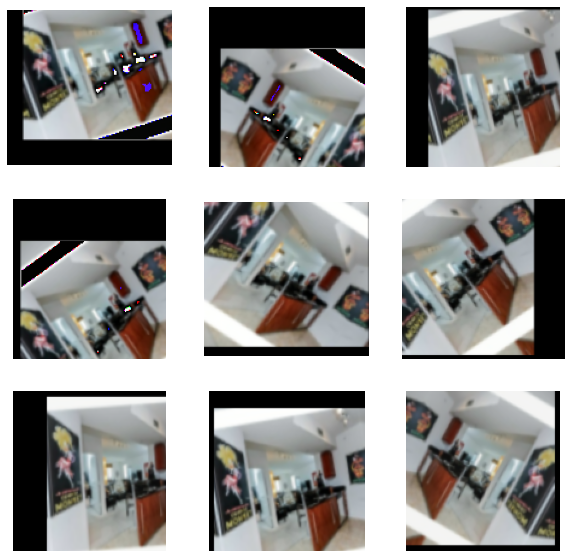

In [ ]:
# https://www.tensorflow.org/guide/keras/preprocessing_layers
data_augmentation = Sequential(  
  [
    layers.RandomFlip("horizontal",input_shape=(image_size[0],image_size[1],3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.005),
    #random_invert(0.2),  # color inversion
    layers.RandomContrast(0.1),
    #Contrast(),
    #layers.RandomCrop(image_size[0],image_size[1]), 
    layers.RandomWidth(0.05, interpolation="gaussian"),
    layers.RandomHeight(0.05),
    layers.RandomTranslation((-0.2,0.3),(-0.2,0.3), fill_mode='constant',interpolation='bilinear', seed=None, fill_value=0.0),
  ]
)

plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

# vgg19 with/without data augmentation

In [ ]:
# VGG16
base_model_vgg16 = VGG16(include_top=False, weights='imagenet', input_shape=(128, 128, 3), classes = 5, classifier_activation='softmax')
base_model_vgg19 = VGG19(include_top=False, weights='imagenet', input_shape=(128, 128, 3), classes = 5, classifier_activation='softmax')
base_model_xception    =  Xception(include_top=False, weights='imagenet', input_shape=(128, 128, 3), classes = 5, classifier_activation='softmax')
base_model_inception   = InceptionResNetV2(include_top=False, weights='imagenet', input_shape=(128, 128, 3), classes = 5, classifier_activation='softmax')
base_model_densenet121 = DenseNet121(include_top=False, weights='imagenet', input_shape=(128, 128, 3), classes = 5) # has no classifier activation args
base_model_resnet50    = ResNet50(include_top=False, weights='imagenet', input_shape=(128, 128, 3), classes = 5) # has no classifier activation args

models_dict = {
    # vgg16
    #"vgg16_NOdataAug_NOdropout"      : vgg19_vgg16(data_augmentation=None,               base_model= base_model_vgg16, dropout_layers=False, dropout_position= None,     dropout_percent=None, num_classes=5),
    #"vgg16_dataAug_dropoutFirst02"   : vgg19_vgg16(data_augmentation=data_augmentation,  base_model= base_model_vgg16, dropout_layers=True,  dropout_position= "first",  dropout_percent=0.2,  num_classes=5),
    #"vgg16_NOdataAug_dropoutFirst02" : vgg19_vgg16(data_augmentation=None,               base_model= base_model_vgg16, dropout_layers=True,  dropout_position= "first",  dropout_percent=0.2,  num_classes=5),
    #"vgg16_dataAug_dropoutMiddle02"  : vgg19_vgg16(data_augmentation=data_augmentation,  base_model= base_model_vgg16, dropout_layers=True,  dropout_position= "middle", dropout_percent=0.2,  num_classes=5),
    #"vgg16_NOdataAug_dropoutMiddle02": vgg19_vgg16(data_augmentation=None,               base_model= base_model_vgg16, dropout_layers=True,  dropout_position= "middle", dropout_percent=0.2,  num_classes=5),
    #"vgg16_dataAug_NOdropout"        : vgg19_vgg16(data_augmentation=data_augmentation,  base_model= base_model_vgg16, dropout_layers=False, dropout_position= None,     dropout_percent=None, num_classes=5),   

    # vgg19
    # "vgg19_NOdataAug_NOdropout"      : vgg19_vgg16(data_augmentation=None,               base_model= base_model_vgg19, dropout_layers=False, dropout_position= None,     dropout_percent=None, num_classes=5),
    # "vgg19_dataAug_dropoutFirst02"   : vgg19_vgg16(data_augmentation=data_augmentation,  base_model= base_model_vgg19, dropout_layers=True,  dropout_position= "first",  dropout_percent=0.2,  num_classes=5),
    # "vgg19_NOdataAug_dropoutFirst02" : vgg19_vgg16(data_augmentation=None,               base_model= base_model_vgg19, dropout_layers=True,  dropout_position= "first",  dropout_percent=0.2,  num_classes=5),
    #"vgg19_dataAug_dropoutMiddle02"  : vgg19_vgg16(data_augmentation=data_augmentation,  base_model= base_model_vgg19, dropout_layers=True,  dropout_position= "middle", dropout_percent=0.2,  num_classes=5),
    # "vgg19_NOdataAug_dropoutMiddle02": vgg19_vgg16(data_augmentation=None,               base_model= base_model_vgg19, dropout_layers=True,  dropout_position= "middle", dropout_percent=0.2,  num_classes=5),
    # "vgg19_dataAug_NOdropout"        : vgg19_vgg16(data_augmentation=data_augmentation,  base_model= base_model_vgg19, dropout_layers=False, dropout_position= None,     dropout_percent=None, num_classes=5),
    
    # xception
    #"xception_NOdataAug_NOdropout"     : generic_last_2layers(data_augmentation=None,  nn=base_model_xception, neurons_final_layer=5, dropout_layers=False, dropout_position=None,     dropout_percent = None),
    # "xception_dataAug_NOdropout"       : generic_last_2layers(data_augmentation,       nn=base_model_xception, neurons_final_layer=5, dropout_layers=False, dropout_position=None,     dropout_percent = None),
    # "xception_dataAug_dropoutFirst02"  : generic_last_2layers(data_augmentation,       nn=base_model_xception, neurons_final_layer=5, dropout_layers=True,  dropout_position="first",  dropout_percent = 0.2),
    # "xception_NOdataAug_dropoutFirst02": generic_last_2layers(data_augmentation= None, nn=base_model_xception, neurons_final_layer=5, dropout_layers=True,  dropout_position="first",  dropout_percent = 0.2),
    #"xception_dataAug_dropoutMid02"    : generic_last_2layers(data_augmentation,       nn=base_model_xception, neurons_final_layer=5, dropout_layers=True,  dropout_position="middle", dropout_percent = 0.2),
    # "xception_NOdataAug_dropoutMid02"  : generic_last_2layers(data_augmentation= None, nn=base_model_xception, neurons_final_layer=5, dropout_layers=True,  dropout_position="middle", dropout_percent = 0.2),
    
    # # inception resnet v2
    # "InceptionResNetV2_NOdataAug_NOdropout"     : generic_last_2layers(data_augmentation=None,  nn=base_model_inception, neurons_final_layer=5, dropout_layers=False, dropout_position=None,     dropout_percent = None),
    # "InceptionResNetV2_dataAug_NOdropout"       : generic_last_2layers(data_augmentation,       nn=base_model_inception, neurons_final_layer=5, dropout_layers=False, dropout_position=None,     dropout_percent = None),
    # "InceptionResNetV2_dataAug_dropoutFirst02"  : generic_last_2layers(data_augmentation,       nn=base_model_inception, neurons_final_layer=5, dropout_layers=True,  dropout_position="first",  dropout_percent = 0.2),
    # "InceptionResNetV2_NOdataAug_dropoutFirst02": generic_last_2layers(data_augmentation= None, nn=base_model_inception, neurons_final_layer=5, dropout_layers=True,  dropout_position="first",  dropout_percent = 0.2),
    # "InceptionResNetV2_dataAug_dropoutMid02"    : generic_last_2layers(data_augmentation,       nn=base_model_inception, neurons_final_layer=5, dropout_layers=True,  dropout_position="middle", dropout_percent = 0.2),
    # "InceptionResNetV2_NOdataAug_dropoutMid02"  : generic_last_2layers(data_augmentation= None, nn=base_model_inception, neurons_final_layer=5, dropout_layers=True,  dropout_position="middle", dropout_percent = 0.2),

    # densenet121
    # "densenet121_NOdataAug_NOdropout"     : generic_last_2layers(data_augmentation=None,  nn=base_model_densenet121, neurons_final_layer=5, dropout_layers=False, dropout_position=None,     dropout_percent = None),
    #"densenet121_dataAug_NOdropout"       : generic_last_2layers(data_augmentation,       nn=base_model_densenet121, neurons_final_layer=5, dropout_layers=False, dropout_position=None,     dropout_percent = None),
    "densenet121_dataAug_dropoutFirst02"  : generic_last_2layers(data_augmentation,       nn=base_model_densenet121, neurons_final_layer=5, dropout_layers=True,  dropout_position="first",  dropout_percent = 0.2),
    # "densenet121_NOdataAug_dropoutFirst02": generic_last_2layers(data_augmentation= None, nn=base_model_densenet121, neurons_final_layer=5, dropout_layers=True,  dropout_position="first",  dropout_percent = 0.2),
    # "densenet121_dataAug_dropoutMid02"    : generic_last_2layers(data_augmentation,       nn=base_model_densenet121, neurons_final_layer=5, dropout_layers=True,  dropout_position="middle", dropout_percent = 0.2),
    # "densenet121_NOdataAug_dropoutMid02"  : generic_last_2layers(data_augmentation= None, nn=base_model_densenet121, neurons_final_layer=5, dropout_layers=True,  dropout_position="middle", dropout_percent = 0.2),

     # resnet50
    #"resnet50_NOdataAug_NOdropout"     : generic_last_2layers(data_augmentation=None,  nn=base_model_resnet50, neurons_final_layer=5, dropout_layers=False, dropout_position=None,     dropout_percent = None),
    #"resnet50_dataAug_NOdropout"       : generic_last_2layers(data_augmentation,       nn=base_model_resnet50, neurons_final_layer=5, dropout_layers=False, dropout_position=None,     dropout_percent = None),
    #"resnet50_dataAug_dropoutFirst02"  : generic_last_2layers(data_augmentation,       nn=base_model_resnet50, neurons_final_layer=5, dropout_layers=True,  dropout_position="first",  dropout_percent = 0.2),
    #"resnet50_NOdataAug_dropoutFirst02": generic_last_2layers(data_augmentation= None, nn=base_model_resnet50, neurons_final_layer=5, dropout_layers=True,  dropout_position="first",  dropout_percent = 0.2),
    #"resnet50_dataAug_dropoutMid02"    : generic_last_2layers(data_augmentation,       nn=base_model_resnet50, neurons_final_layer=5, dropout_layers=True,  dropout_position="middle", dropout_percent = 0.2),
    # "resnet50_NOdataAug_dropoutMid02"  : generic_last_2layers(data_augmentation= None, nn=base_model_resnet50, neurons_final_layer=5, dropout_layers=True,  dropout_position="middle", dropout_percent = 0.2),
}

94781440/94765736 [==============================] - 1s 0us/step



 densenet121_dataAug_dropoutFirst02
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, None, None, 3)     0         
                                                                 
 rescaling (Rescaling)       (None, None, None, 3)     0         
                                                                 
 densenet121 (Functional)    (None, 4, 4, 1024)        7037504   
                                                                 
 dropout (Dropout)           (None, 4, 4, 1024)        0         
                                                                 
 global_average_pooling2d (G  (None, 1024)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 5)                 5125      
                 

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


33/33 [==============================] - 909s 28s/step - loss: 1.6055 - accuracy: 0.2957 - val_loss: 1.7432 - val_accuracy: 0.3552
Epoch 2/300
33/33 [==============================] - 13s 346ms/step - loss: 1.3362 - accuracy: 0.4488 - val_loss: 1.2755 - val_accuracy: 0.5019
Epoch 3/300
33/33 [==============================] - 13s 337ms/step - loss: 1.2325 - accuracy: 0.4888 - val_loss: 1.2022 - val_accuracy: 0.5362
Epoch 4/300
33/33 [==============================] - 13s 355ms/step - loss: 1.1859 - accuracy: 0.5093 - val_loss: 1.1499 - val_accuracy: 0.5648
Epoch 5/300
33/33 [==============================] - 12s 327ms/step - loss: 1.1636 - accuracy: 0.5229 - val_loss: 1.0701 - val_accuracy: 0.5962
Epoch 6/300
33/33 [==============================] - 12s 329ms/step - loss: 1.1236 - accuracy: 0.5426 - val_loss: 1.0302 - val_accuracy: 0.6038
Epoch 7/300
33/33 [==============================] - 13s 342ms/step - loss: 1.1139 - accuracy: 0.5519 - val_loss: 1.0400 - val_accuracy: 0.5952
Epoch

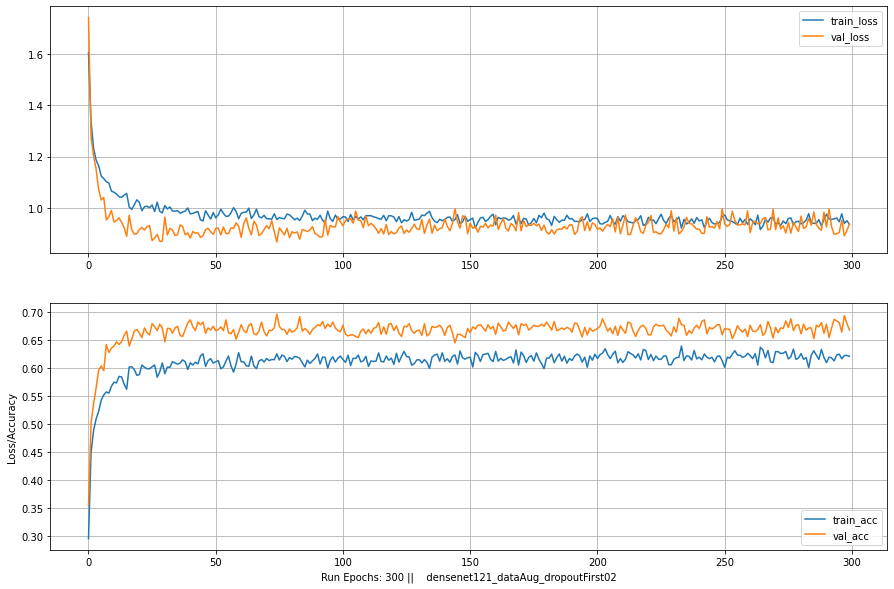

9/9 [==============================] - 2s 79ms/step - loss: 0.9366 - accuracy: 0.6676


AttributeError: ignored

In [ ]:
callbacks = [
    EarlyStopping(
        # Stop training when the metric is no longer improving
        monitor="val_accuracy", mode="max", #  "val_loss",
        # "no longer improving" being defined as "no better than 1e-4 less"
        min_delta=1e-4,
        # "no longer improving" being further defined as "for at least 10 epochs"
        patience=10,
        verbose=1
    )
]

epochs = 300
for m in models_dict:
  print("\n", m)
  models_dict[m].summary()

  models_dict[m].compile( optimizer = "adam", 
                loss=SparseCategoricalCrossentropy(from_logits=True) ,#'categorical_crossentropy', , 
                metrics=['accuracy'] # "recall"
                )

  history = models_dict[m].fit(
        train_ds,
        validation_data=val_ds,
        epochs=epochs,
        #callbacks = callbacks # <=== REMOVE CALLBACK for full results
        )
  
  number_of_epochs_it_ran = len(history.history['loss']) 
  print("run epochs: ",number_of_epochs_it_ran)
  name = m
  models_dict[m].save(output_folder+name+".h5")

  # saving model accuracy/loss graph
  plotting_model(history,number_of_epochs_it_ran, name, output_folder+name+"-loss_accuracy.png") 
  
  # saving model metrics to json
  evaluation = models_dict[m].evaluate(val_ds, batch_size=batch_size, return_dict=True)
  model_evaluation(evaluation, output_folder, name)

  # get inferences
  y_pred_float = models_dict[m].predict(val_ds)
  y_pred = np.argmax(y_pred_float, axis=1) 

  # classification and confusion matrix reports
  classification_report_pic(y_pred, validation_ds,  class_names, output_folder, name)
  confusion_matrix_report(y_pred, validation_ds, class_names, output_folder, name)

- load a trained model

In [ ]:
# error above for misplacing y_pred and val_ds in function args
densenet121 = load_model(output_folder+"densenet121_dataAug_dropoutFirst02.h5")
evaluation  = densenet121.evaluate(val_ds, batch_size=batch_size, return_dict=True)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


9/9 [==============================] - 144s 117ms/step - loss: 0.9366 - accuracy: 0.6676


In [ ]:
# saving model metrics to json
model_evaluation(evaluation, output_folder, "densenet121_dataAug_dropoutFirst02.h5")

{'densenet121_dataAug_dropoutFirst02': {'accuracy': 0.6676190495491028,
  'loss': 0.9365859627723694}}

In [ ]:
# get inferences
y_pred_float = models_dict[m].predict(val_ds)
y_pred = np.argmax(y_pred_float, axis=1) 

              precision    recall  f1-score   support

     Bedroom       0.00      0.33      0.01         3
    Bathroom       0.02      0.06      0.03        32
     Dinning       0.11      0.25      0.16       111
  Livingroom       0.13      0.29      0.18       116
     Kitchen       0.76      0.20      0.31       788

    accuracy                           0.21      1050
   macro avg       0.21      0.23      0.14      1050
weighted avg       0.60      0.21      0.27      1050



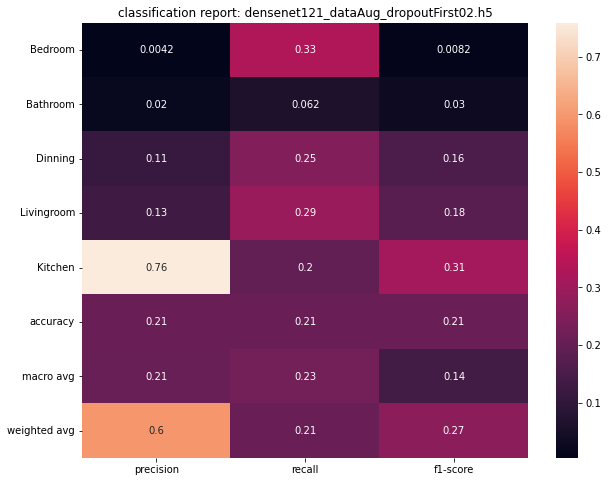

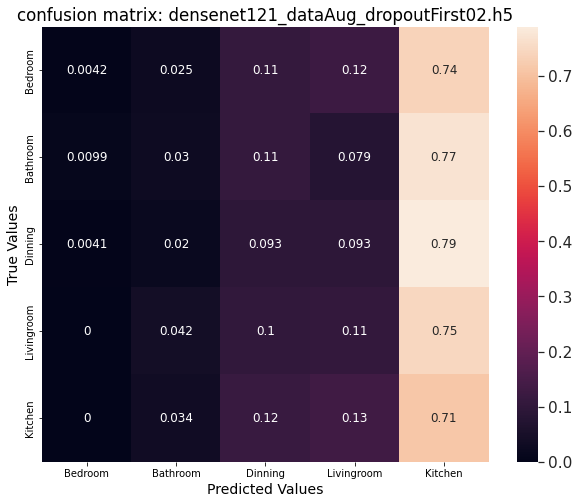

In [ ]:
# classification and confusion matrix reports
classification_report_pic(y_pred, val_ds,  class_names, output_folder, "densenet121_dataAug_dropoutFirst02.h5")
confusion_matrix_report(y_pred, val_ds, class_names, output_folder, "densenet121_dataAug_dropoutFirst02.h5")

# compiling and running code manually

manual example of what we're doing above

In [ ]:
asdfasdfasdfasf

In [ ]:
# this is a nn from a dictionary written above. create the nn ready for transfer-learning
vgg19_dict["vgg19_dataAug_dropoutFirst0.2"].compile( optimizer = "adam", 
                 loss=SparseCategoricalCrossentropy(from_logits=True) ,#'categorical_crossentropy', , 
                metrics=['accuracy'] 
                )

# callbacks just for first approach
callbacks = [
    keras.callbacks.EarlyStopping(
        # Stop training when `val_loss` is no longer improving
        monitor="val_loss",
        # "no longer improving" being defined as "no better than 1e-2 less"
        min_delta=1e-2,
        # "no longer improving" being further defined as "for at least 2 epochs"
        patience=2,
        verbose=1,
    )
]

epochs = 200
# fit the model
history = vgg19_dict["vgg19_dataAug_dropoutFirst0.2"].fit(
      train_ds,
      validation_data=val_ds,
      epochs=epochs,
      #callbacks = callbacks
      )

In [ ]:
def plotting_model(model, epochs, name, location):
  #Plotting the training and validation loss and accuracy
  
  f,ax=plt.subplots(2,1,figsize=(15,10))
  #Loss
  ax[0].plot(np.arange(0, epochs), model.history["loss"], label="train_loss")
  ax[0].plot(np.arange(0, epochs), model.history["val_loss"], label="val_loss")
  ax[0].grid(True)
  ax[0].legend()

  plt.xlabel("Epoch #")
  plt.ylabel("Loss/Accuracy")
  #Accuracy
  ax[1].plot(np.arange(0, epochs), model.history["accuracy"], label="train_acc")
  ax[1].plot(np.arange(0, epochs), model.history["val_accuracy"], label="val_acc")
  ax[1].legend()
  #plt.legend()
  plt.xlabel("Run Epochs: "+str(epochs)+" ||    "+name)
  plt.ylabel("Loss/Accuracy")
  ax[1].grid(True)
  #ax[0].title("Training Loss and Accuracy", loc="left")
  plt.savefig(location)
  plt.show()

### saving the model. loss/accuracy

In [ ]:
# loss/accuracy and saving the model
number_of_epochs_it_ran = len(history.history['loss']) 
print(number_of_epochs_it_ran)
name = "vgg19_dataAug_dropoutFirst0.2"
vgg19_dict["vgg19_dataAug_dropoutFirst0.2"].save(output_folder+name+".h5")

plotting_model(history,number_of_epochs_it_ran, name, output_folder+name+"-loss_accuracy.png") 

### model performance

In [ ]:
# evaluation the model with val_ds
models_metrics = {}
evaluation = vgg19_dict["vgg19_dataAug_dropoutFirst0.2"].evaluate(val_ds, batch_size=batch_size, return_dict=True)
models_metrics["vgg19_dataAug_dropoutFirst0.2"] = evaluation
models_metrics

In [ ]:
import json
# saving the metrics in a json
with open(name+"-metrics.json", "w") as outfile:
    json.dump(models_metrics, outfile)

### saving the classifitacion report to a file

we need a flat array of real labels, and a flat one of infererd labels in order to create our sk-learn classification report, and it's tricky somehow.
- the inferred labels come as a float array (with percentage of belonging to a class), we have to transform it into an int array, where the highest probabilities are turned into a 1 and rest into 0.
- the real labels are inserted into the val_ds tensorflow stuff, and we have to extract the info saved in batches out of there), and create the array.

In [ ]:
# create inferences
y_pred_float = vgg19_dict["vgg19_dataAug_dropoutFirst0.2"].predict(val_ds)
print(y_pred_float.shape)
# now let's turn it into a 1050x1 array, where it's value will be the associated class
y_pred = np.argmax(y_pred_float, axis=1) 
print(y_pred.shape)

# extract the real labels
numeric_values_val = list(val_ds.map(lambda x, y: y))
y_target = []


# real lables are kind of a list of  lists, with as much lists as batches we had
for arr in numeric_values_val:
  y_target.append(arr)
# flatten it to a list
y_target = list(chain.from_iterable(y_target))
# transform to a np array
y_target = np.array(y_target)
y_target.shape

# classification report
print(classification_report(y_pred , y_target, target_names=class_names))
# create a image from that output
clf_report = classification_report(y_pred , y_target, target_names=class_names,output_dict=True )
plt.figure(figsize = (10,8))
plt.title("vgg19_dataAug_dropoutFirst0.2")
# .iloc[:-1, :] to exclude support
sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T, annot=True)
plt.savefig(output_folder+name+"-classification_report.png")
plt.show()

### confusion matrix

In [ ]:
from sklearn.metrics import plot_confusion_matrix
#from sklearn.metrics import plot_precision_recall_curve
cm = confusion_matrix(y_pred, y_target)

In [ ]:
class_names

In [ ]:
true_categories = tf.concat([y for x, y in val_ds], axis=0)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(true_categories, y_pred, normalize="true" ) #,  labels=[class_names])
df_cm = pd.DataFrame(cm, index= [class_names], columns = [class_names])
fig = plt.figure(figsize = (10,8))
ax1 = fig.add_subplot(1,1,1)
sns.set(font_scale=1.4) #for label size
sns.heatmap(df_cm, annot=True, annot_kws={"size": 12})
plt.title("confusion matrix: "+name)
ax1.set_ylabel('True Values',fontsize=14)
ax1.set_xlabel('Predicted Values',fontsize=14)
plt.savefig(output_folder+name+"-confusion_matrix.png")
plt.show()